<a href="https://colab.research.google.com/github/bchehab/TensorFlow-2.0-Customer-Churn/blob/master/churn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
pip install keras_radam

In [4]:
from __future__ import absolute_import, division, print_function, unicode_literals

import numpy as np
import pandas as pd

try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf

from tensorflow import feature_column
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from keras_radam import RAdam

Using TensorFlow backend.


In [0]:
from matplotlib import pyplot as plt

In [6]:
dataframe = pd.read_csv('WA_Fn-UseC_-Telco-Customer-Churn.csv')
dataframe.Churn = (dataframe.Churn == 'Yes')*1
dataframe.SeniorCitizen = dataframe.SeniorCitizen.map({True: 'Yes', False: 'No'})
dataframe

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,Female,No,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,0
1,Male,No,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,0
2,Male,No,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,1
3,Male,No,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,0
4,Female,No,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,1
5,Female,No,No,No,8,Yes,Yes,Fiber optic,No,No,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check,99.65,820.50,1
6,Male,No,No,Yes,22,Yes,Yes,Fiber optic,No,Yes,No,No,Yes,No,Month-to-month,Yes,Credit card (automatic),89.10,1949.40,0
7,Female,No,No,No,10,No,No phone service,DSL,Yes,No,No,No,No,No,Month-to-month,No,Mailed check,29.75,301.90,0
8,Female,No,Yes,No,28,Yes,Yes,Fiber optic,No,No,Yes,Yes,Yes,Yes,Month-to-month,Yes,Electronic check,104.80,3046.05,1
9,Male,No,No,Yes,62,Yes,No,DSL,Yes,Yes,No,No,No,No,One year,No,Bank transfer (automatic),56.15,3487.95,0


In [8]:
train, val = train_test_split(dataframe, test_size=0.2)
#train, val = train_test_split(train, test_size=0.2)
print(len(train), 'train examples')
print(len(val), 'validation examples')
#print(len(test), 'test examples')

5634 train examples
1409 validation examples


In [0]:
# A utility method to create a tf.data dataset from a Pandas Dataframe
def df_to_dataset(dataframe, shuffle=True, batch_size=32):
  dataframe = dataframe.copy()
  labels = dataframe.pop('Churn')
  ds = tf.data.Dataset.from_tensor_slices((dict(dataframe), labels))
  if shuffle:
    ds = ds.shuffle(buffer_size=len(dataframe))
  ds = ds.batch(batch_size)
  return ds

In [0]:
feature_columns = []

# numeric cols
for header in ['MonthlyCharges','TotalCharges','tenure']:
  feature_columns.append(feature_column.numeric_column(header))


# indicator cols
for col in dataframe.drop(['MonthlyCharges', 'TotalCharges','tenure','Churn'], axis=1).columns:
    col_feature = feature_column.categorical_column_with_vocabulary_list(
          col, dataframe[col].unique())
    col_one_hot = feature_column.indicator_column(col_feature)
    feature_columns.append(col_one_hot)

In [0]:
feature_layer = tf.keras.layers.DenseFeatures(feature_columns)

In [0]:
batch_size = 64
train_ds = df_to_dataset(train, batch_size=batch_size)
val_ds = df_to_dataset(val, shuffle=False, batch_size=batch_size)
#test_ds = df_to_dataset(test, shuffle=False, batch_size=batch_size)

In [16]:
    model = tf.keras.Sequential([
      feature_layer,
      layers.BatchNormalization(),
      layers.Dense(64, activation='relu'),
      #layers.Dropout(0.2),
      layers.Dense(32, activation='relu'),
      #layers.Dropout(0.2),
      layers.Dense(1, activation='sigmoid')
    ])

    adam = tf.keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999, amsgrad=False)
    sgd = tf.keras.optimizers.SGD(lr=0.0001, momentum=0.9)
    rAdam = RAdam(total_steps=20, warmup_proportion=0.1, min_lr=1e-5)

    model.compile(adam,
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    
    # Create a callback that saves the model's weights
    cp = tf.keras.callbacks.ModelCheckpoint(filepath='model',
                                                     save_weights_only=True,
                                                     monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

    es = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, patience=30)

    history = model.fit(train_ds, 
                        validation_data=val_ds,
                        callbacks=[cp,es],
                        epochs=500,
                        verbose=0)


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.


Epoch 00001: val_accuracy improved from -inf to 0.71753, saving model to model

Epoch 00002: val_accuracy improved from 0.71753 to 0.75656, saving model to model

Epoch 00003: val_accuracy improved from 0.75656 to 0.77999, saving model to model

Epoch 00004: val_accuracy improved from 0.77999 to 0.79134, saving model to model

Epoch 00005: val_accuracy improved from 0.79134 to 0.79560, saving model to model

Epoch 00006: val_accuracy improved from 0.79560 to 0.79631, saving model to model

Epoch 00007:

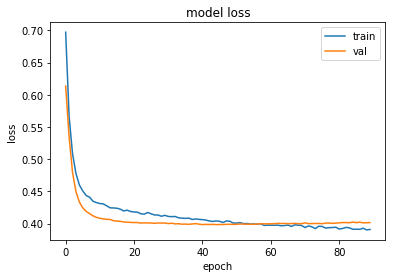

In [17]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

In [41]:
model.load_weights('model')

In [42]:
loss,accuracy = model.evaluate(val_ds)
print('validation loss: ', loss)
print('validation accuracy: ', accuracy)

23/23 [==============================] - 0s 4ms/step - loss: 0.3995 - accuracy: 0.8077
validation loss:  0.3995186984539032
validation accuracy:  0.807665


In [0]:
results = val.copy()

In [43]:
results = results.assign(predicted = (model.predict(val_ds) >= 0.5)*1)
results.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,predicted
2800,Female,No,Yes,Yes,20,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Month-to-month,No,Mailed check,20.35,442.60,0,0
1988,Male,Yes,Yes,No,58,Yes,Yes,Fiber optic,Yes,Yes,Yes,No,Yes,Yes,One year,Yes,Electronic check,108.85,6287.25,1,0
284,Male,No,Yes,Yes,18,Yes,No,Fiber optic,No,No,Yes,No,Yes,Yes,Month-to-month,No,Mailed check,95.15,1779.95,1,1
2996,Female,No,No,No,18,Yes,Yes,DSL,Yes,No,Yes,No,No,No,Month-to-month,Yes,Mailed check,60.60,1156.35,0,0
4143,Male,No,No,No,25,Yes,Yes,Fiber optic,No,No,No,No,No,Yes,Month-to-month,Yes,Electronic check,84.80,2043.45,1,1
